# Mathematical Modelling for Sustainable Development
## Coursework Submission 2025
### Serena Farrelly

Question 2: Tipping points and the Greenland ice sheet

Modelling the interplay between global temperatures and albedo affect to predict the melting of the greenland icesheet.


### Modelling Assumptions

- parabolic ice sheet cross section

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import sympy as sym

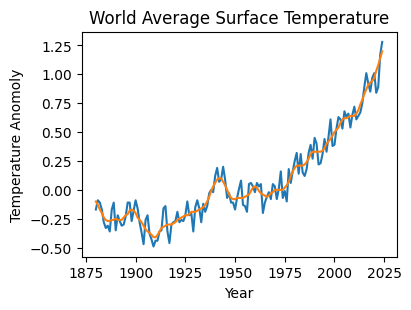

In [19]:
with open("temperature.txt", "r") as file:
    lines = file.readlines()  # Read all lines into a list

# get rid of initial headers
lines = lines[5:len(lines)]

# Process each line
data = [line.strip().split() for line in lines]  # Removes '\n' and splits by space
processed_data = [[int(line[0]), float(line[1]), float(line[2])] for line in data]

# putting into a np array
NASAtemp = np.array(processed_data)
# print(np.shape(NASAtemp))

fig = plt.figure(figsize=(9,3))
ax1 = fig.add_axes([0.10, 0.15, 0.35, 0.75])
ax1.plot(NASAtemp[:,0], NASAtemp[:,1])
ax1.plot(NASAtemp[:,0], NASAtemp[:,2])
ax1.set_xlabel('Year')
ax1.set_ylabel('Temperature Anomoly')
ax1.set_title('World Average Surface Temperature')
plt.show()

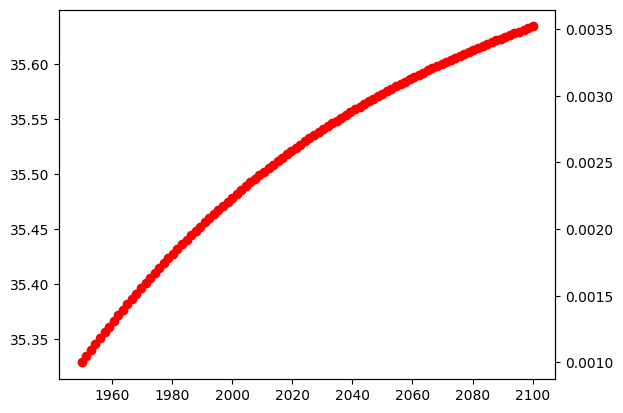

In [ ]:
# we also want how betastar changes with time
# assuming emissions increase linearly
gamma = 0.001           # rate of linear emissions (to be calibrated)
def get_E(t, gamma):
    E_1950 = 5.2e9      # CO2 emissions in 1950 (tonnes)
    E = gamma*(t-1950)+E_1950
    return E

start_year = 1950
end_year = 2100
t = np.linspace(start_year, end_year, 100)
E_arr = get_E(t, gamma)

## need to check that this is ok to remain as annual emissions rather than cumulative CO2 levels

# how emissions relate to CO2 air density
def drho_dt(E, rho):
    kappa = 0.005           # coefficient (to be calibrated)
    t_CO2 = 100             # life span of CO2 in atmosphere (years)
    rho_1950 = 315          # technically 1959 (ppm)
    return kappa*E - (1/t_CO2)*(rho-rho_1950)

rho_0 = 315             # initial condition
# integrate to find the CO2 air density at current emissions level (for the year)
rho = solve_ivp(drho_dt, [start_year, end_year], [rho_0], t_eval=t)
# print(rho)

# how CO2 air density relates to betastar
G = (1/315)*0.001              # proportionality constant (to be calibrated)
# calibration philosophy: they be smol (<0.1)
betastar = G*rho.y[0]          # array of man-made greenhouse effect values

# print(betastar)

def T(betastar, T_0):
    alpha = 0.3         # albedo effect
    beta = 0.4          # greenhouse effect
    sigma = 5.67e-8     # Stefan-Boltzmann constant
    R_in = 340          # incoming solar energy (W/m^2)
    d_T = (((1-alpha)*R_in) / ((1-(beta+betastar))*sigma))**0.25 - T_0
    return d_T



d_T_arr = T(betastar, T_0)
# print(d_T_arr)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(t,d_T_arr)
ax2.plot(t,betastar, "ro-")
plt.show()

In [21]:
# we need to feed these temperatures into melting term of the ice sheet height model
# lets get some shit down

# rate of change of height of ice sheet
def dh_dt(d_T, h):
    P = 4           # precipitation rate (m/yr)
    r = 1           # rate at which ice melts (dependent on temperature)
    T_0 = 273-19    # pre-industrial surface temp (K)
    h_f = 100       # characteristic length, altitude above which the ice won't melt
    F = 1           # rate of flow of ice sheet into the sea

    dh_dt = P - (r*(T_0+d_T))/(h+h_f)-(F*h)
    if h <= 0 and dh_dt < 0:
        dh_dt = 0
    return dh_dt



# integrate to find the CO2 air density at current emissions level (for the year)
# h_arr = solve_ivp(dh_dt, [min(d_T_arr), max(d_T_arr)], [h_0], t_eval=d_T_arr)

# plt.plot(t,h_arr.y[0])
# plt.show()

In [71]:
# lets turn this into a happy little dome
# volumes of rotation yeah (A-level flashbacks)

width = 980000         # width of the GrIS
y = sym.symbols('y')
Vol = sym.integrate(np.pi*((3000-y)/(3000/(width/2)**2)), (y, 0, 3000))
print(Vol)

def get_melt_vol(h, h_0, Vol):
    sf = h/h_0
    return Vol - (sf**3 * Vol)

# total_ice_melt = get_melt_vol(h_arr.y[0][-1],h_0,Vol)

# print(total_ice_melt)

1.13144459419036e+15


In [23]:
# https://blog.truegeometry.com/calculators/What_is_the_estimated_sea_level_rise_in_meters_if_the_volume_of_the_world_s_oceans_increases_by_15_d.html

# convert the volume ice melt into world sea level rise

def sea_level_rise(Vol):
    # vol_ocean = 1.335e18
    SA_ocean = 3.618e14         # ocean surface area (m^2)
    return Vol/SA_ocean

# sea_level_rise = sea_level_rise(total_ice_melt)

# print(sea_level_rise)

In [53]:
# feedback to albedo effect
# as ocean surface area increases albedo affect increases

def get_albedo(vol):
    # get scaling factor (as melt volume goes up, ocean SA goes up)
    vol_ocean = 1.335e18
    # zero check
    if vol == 0:
        sf = 0
    else:
        sf = (vol/vol_ocean)**(2/3)
    # albedo is proportional to dark surface area
    return 0.4+(0.9*sf)


def T(betastar, T_0, alpha):
    beta = 0.4                      # greenhouse effect
    sigma = 5.67e-8                 # Stefan-Boltzmann constant
    Q = 340                         # incoming solar energy (W/m^2)
    d_T = (((1-alpha)*Q) / ((1-(beta+betastar))*sigma))**0.25 - T_0
    return d_T

In [ ]:
def get_E(t, gamma):
    E_1950 = 5.2e9      # CO2 emissions in 1950 (tonnes)
    E = gamma*(t-1950)+E_1950
    return E

def drho_dt(t, rho):
    kappa = 0.005           # coefficient (to be calibrated)
    t_CO2 = 100             # life span of CO2 in atmosphere (years)
    rho_1950 = 315          # technically 1959 (ppm)
    E = get_E(t, gamma)     # getting variable E
    return kappa*E - (1/t_CO2)*(rho-rho_1950)

# how CO2 air density relates to betastar
G = (1/315)*0.001              # proportionality constant (to be calibrated)
betastar = G*rho

def T(betastar, T_0, alpha):
    beta = 0.4                      # greenhouse effect
    sigma = 5.67e-8                 # Stefan-Boltzmann constant
    Q = 340                         # incoming solar energy (W/m^2)
    d_T = (((1-alpha)*Q) / ((1-(beta+betastar))*sigma))**0.25 - T_0
    return d_T

# rate of change of height of ice sheet
def dh_dt(d_T, h):
    P = 4           # precipitation rate (m/yr)
    r = 1           # rate at which ice melts (dependent on temperature)
    T_0 = 273-19    # pre-industrial surface temp (K)
    h_f = 100       # characteristic length, altitude above which the ice won't melt
    F = 1           # rate of flow of ice sheet into the sea

    dh_dt = P - (r*(T_0+d_T))/(h+h_f)-(F*h)
    if h <= 0 and dh_dt < 0:
        dh_dt = 0
    return dh_dt

In [70]:
# do a for loop to iterate through time
start_year = 1950
end_year = 2100
n_int = 100

t = np.linspace(start_year+1, end_year, n_int)
# print(t[0])
# saving results
E_arr = rho_arr = betastar_arr = alpha_arr = T_arr = h_arr = vol_arr = SLR_arr = np.zeros([n_int,1])

# set initial conditions
E_0 = 5.2e9                 #
h_0 = 3000                  # ice sheet height initial condition
T_0 = 273-19                # temperature initial condition
rho_0 = 315                 # CO2 density initial condition
alpha_arr[0] = 0.4          # inital average albedo
T_arr[0] = T_0+1            # initial condition temperature
E_arr[0] = E_0              # intial condition for E_arr[0]
T_max = 900                 # max temp for dh_dt solver
E_max = E_0+50              # max emissions for rho solver

# modelling parameters
gamma = 0.001               # rate of linear emissions (to be calibrated)

for i in range(len(t)-1):
    E_arr[i+1] = get_E(t[i], gamma)
    print(t[i])
    print(E_arr[i])
    rho = solve_ivp(drho_dt, [start_year, end_year], [rho_0], t_eval=[t[i]])
    rho_arr[i+1] = rho.y[0]
    print(rho_arr[i])
    betastar_arr[i+1] = G*rho.y[0]
    print(betastar_arr[i])


    T_arr[i+1] = T(betastar_arr[i], T_0, alpha_arr[i])
    # print(T_arr[i][0])

    # lets get that height
    h = solve_ivp(dh_dt, [-1, T_max], [h_0], t_eval=[T_arr[i][0]])
    h_arr[i+1] = h.y[0]


    # convert into volume ice melt
    vol_arr[i+1] = get_melt_vol(h_arr[i], h_0, Vol)
    
    alpha_arr[i+1] = get_albedo(vol_arr[i])
    # convert in to global SLR
    SLR_arr[i+1] = sea_level_rise(vol_arr[i])
    

plt.plot(t,E_arr)
plt.show()

1951.0
[5.2e+09]
[5.2e+09]
[5.2e+09]


ValueError: Values in `t_eval` are not within `t_span`.